In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import shutil

# Set the path to the folder containing the images and masks
path = "/content/drive/MyDrive/training_set"

# Create folders for images and masks
image_folder = os.path.join(path, "images")
mask_folder = os.path.join(path, "masks")

os.makedirs(image_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

# Loop through all files in the folder and move them to their respective folder
for file_name in os.listdir(path):
    if file_name.endswith("_Annotation.jpg") or file_name.endswith("_Annotation.png"):
        shutil.move(os.path.join(path, file_name), os.path.join(mask_folder, file_name))
    elif file_name.endswith(".jpg") or file_name.endswith(".png"):
        shutil.move(os.path.join(path, file_name), os.path.join(image_folder, file_name))

In [10]:
import numpy as np
import torch
import os
# base path of the dataset
DATASET_PATH = '/content/drive/My Drive/training_set'
# define the pah to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
VALID_SPLIT = 0.2
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [12]:
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 24
BATCH_SIZE = 16
# define the input image dimensions
INPUT_IMAGE_WIDTH = 800
INPUT_IMAGE_HEIGHT = 540
# define threshold to filter weak predictions
THRESHOLD = 0.7

In [13]:
BASE_OUTPUT = '/content/drive/MyDrive/output'
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
os.listdir(IMAGE_DATASET_PATH)

In [15]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [16]:

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch 

In [17]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [18]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [19]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [20]:

class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [21]:
def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [22]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [24]:
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
split = train_test_split(imagePaths, maskPaths,test_size= 0.2, random_state=24)
# unpack the data split
(trainImages, validImages) = split[:2]
(trainMasks, validMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(validImages))
f.close()

[INFO] saving testing image paths...


In [ ]:
!pwd

In [25]:

import torchvision.transforms as transforms

In [26]:
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=validImages, maskPaths=validMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the val set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 799 examples in the training set...
[INFO] found 200 examples in the val set...


In [27]:
unet = UNet().to(DEVICE)
import torch

In [28]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 29.3 MB/s eta 0:00:00


In [29]:
import torch

def dice_coefficient(pred, target):
    """
    Compute the Dice coefficient between predicted and target tensors.
    Args:
        pred: predicted tensor with shape (batch_size, num_classes, height, width)
        target: target tensor with shape (batch_size, num_classes, height, width)
    Returns:
        Dice coefficient value between 0 and 1.
    """
    smooth = 1e-6

    # Flatten tensors
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    # Compute intersection and union
    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)

    # Compute Dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)
    dice = dice.mean()

    return dice

In [30]:
import torch
import torchmetrics
# from torchmetrics import Dice
# dice = Dice(average='micro')
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [31]:
from torchmetrics.classification import dice
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = dice_coefficient(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += dice_coefficient(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Validation loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  4%|▍         | 1/24 [05:19<2:02:32, 319.67s/it]

[INFO] EPOCH: 1/24
Train loss: 0.020266, Validation loss: 0.0256


  8%|▊         | 2/24 [05:55<56:02, 152.86s/it]  

[INFO] EPOCH: 2/24
Train loss: 0.023292, Validation loss: 0.0232


 12%|█▎        | 3/24 [06:31<34:48, 99.44s/it] 

[INFO] EPOCH: 3/24
Train loss: 0.014656, Validation loss: 0.0072


 17%|█▋        | 4/24 [07:08<24:54, 74.73s/it]

[INFO] EPOCH: 4/24
Train loss: 0.004955, Validation loss: 0.0222


 21%|██        | 5/24 [07:43<19:11, 60.58s/it]

[INFO] EPOCH: 5/24
Train loss: 0.020478, Validation loss: 0.0112


 25%|██▌       | 6/24 [08:20<15:45, 52.52s/it]

[INFO] EPOCH: 6/24
Train loss: 0.004689, Validation loss: 0.0033


 29%|██▉       | 7/24 [08:56<13:21, 47.14s/it]

[INFO] EPOCH: 7/24
Train loss: 0.002337, Validation loss: 0.0017


 33%|███▎      | 8/24 [09:33<11:39, 43.70s/it]

[INFO] EPOCH: 8/24
Train loss: 0.001103, Validation loss: 0.0008


 38%|███▊      | 9/24 [10:09<10:20, 41.38s/it]

[INFO] EPOCH: 9/24
Train loss: 0.000694, Validation loss: 0.0006


 42%|████▏     | 10/24 [10:45<09:15, 39.68s/it]

[INFO] EPOCH: 10/24
Train loss: 0.000570, Validation loss: 0.0005


 46%|████▌     | 11/24 [11:22<08:25, 38.89s/it]

[INFO] EPOCH: 11/24
Train loss: 0.000489, Validation loss: 0.0005


 50%|█████     | 12/24 [11:57<07:33, 37.79s/it]

[INFO] EPOCH: 12/24
Train loss: 0.008767, Validation loss: 0.0217


 54%|█████▍    | 13/24 [12:34<06:52, 37.49s/it]

[INFO] EPOCH: 13/24
Train loss: 0.020264, Validation loss: 0.0218


 58%|█████▊    | 14/24 [13:10<06:08, 36.88s/it]

[INFO] EPOCH: 14/24
Train loss: 0.019991, Validation loss: 0.0207


 62%|██████▎   | 15/24 [13:45<05:29, 36.59s/it]

[INFO] EPOCH: 15/24
Train loss: 0.017159, Validation loss: 0.0163


 67%|██████▋   | 16/24 [14:21<04:49, 36.24s/it]

[INFO] EPOCH: 16/24
Train loss: 0.013704, Validation loss: 0.0137


 71%|███████   | 17/24 [14:57<04:13, 36.21s/it]

[INFO] EPOCH: 17/24
Train loss: 0.011795, Validation loss: 0.0122


 75%|███████▌  | 18/24 [15:33<03:36, 36.03s/it]

[INFO] EPOCH: 18/24
Train loss: 0.010629, Validation loss: 0.0112


 79%|███████▉  | 19/24 [16:09<03:00, 36.01s/it]

[INFO] EPOCH: 19/24
Train loss: 0.009782, Validation loss: 0.0101


 83%|████████▎ | 20/24 [16:44<02:23, 35.91s/it]

[INFO] EPOCH: 20/24
Train loss: 0.007361, Validation loss: 0.0064


 88%|████████▊ | 21/24 [17:21<01:48, 36.24s/it]

[INFO] EPOCH: 21/24
Train loss: 0.005075, Validation loss: 0.0048


 92%|█████████▏| 22/24 [17:58<01:12, 36.43s/it]

[INFO] EPOCH: 22/24
Train loss: 0.004164, Validation loss: 0.0104


 96%|█████████▌| 23/24 [18:33<00:36, 36.08s/it]

[INFO] EPOCH: 23/24
Train loss: 0.004868, Validation loss: 0.0019


100%|██████████| 24/24 [19:10<00:00, 47.95s/it]

[INFO] EPOCH: 24/24
Train loss: 0.001721, Validation loss: 0.0016
[INFO] total time taken to train the model: 1150.83s


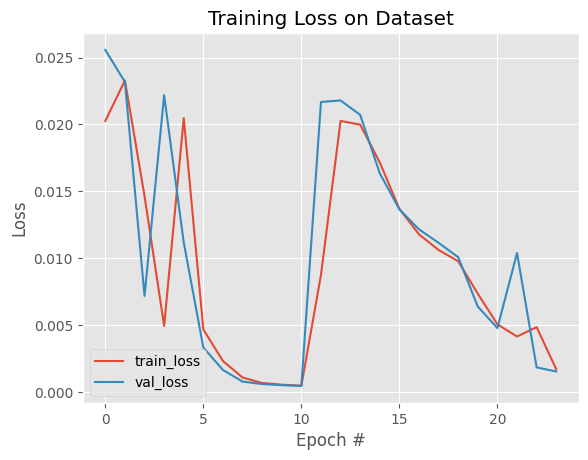

In [32]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [64]:
DATASET_PATH2 = '/content/drive/MyDrive/test_set'
IMAGE_DATASET_PATH2 = os.path.join(DATASET_PATH2, "images")
BASE_OUTPUT2 = '/content/drive/MyDrive/output2'
PLOT_PATH2 = os.path.sep.join([BASE_OUTPUT2, "plot.png"])
TEST_PATHS2 = os.path.sep.join([BASE_OUTPUT2, "test_paths.txt"])

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [66]:
imagePaths2 = sorted(list(paths.list_images(BASE_OUTPUT2)))
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS2, "w")
f.write("\n".join(validImages))
f.close()

[INFO] saving testing image paths...


In [67]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
    		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, predMask)

In [68]:
torch.save(unet, MODEL_PATH)

[INFO] loading up test image paths...
[INFO] load up model...


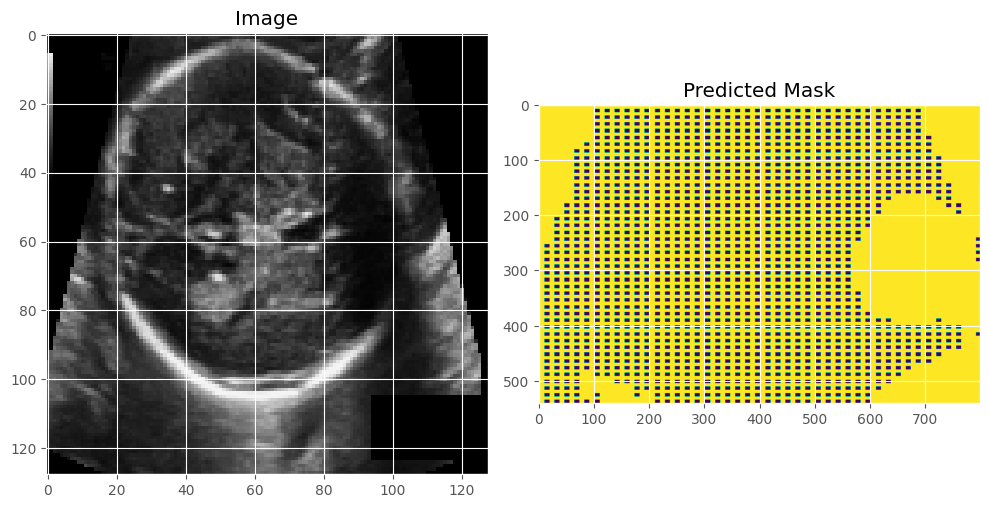

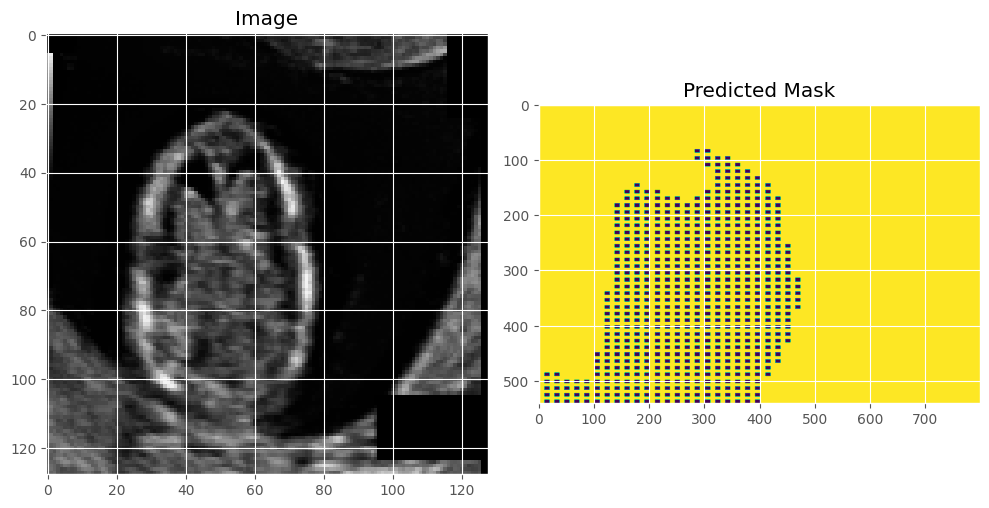

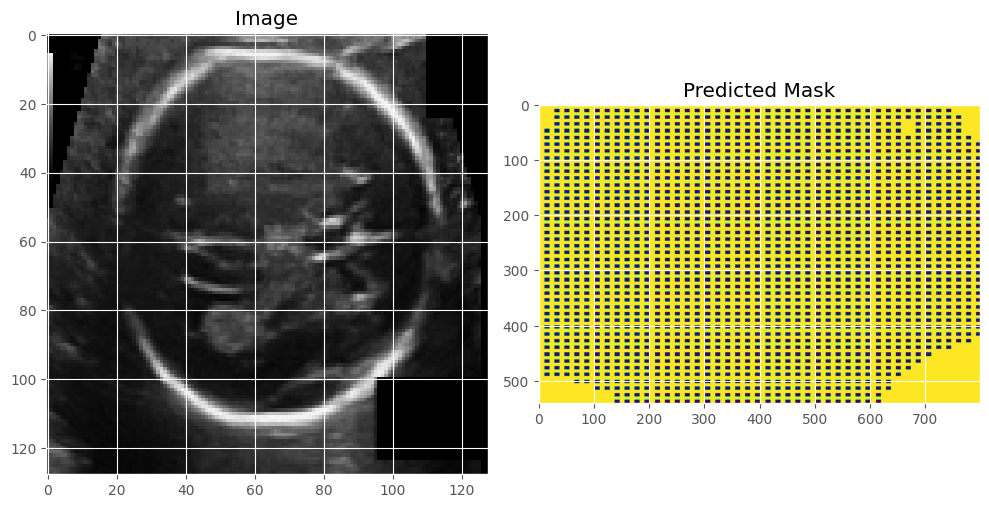

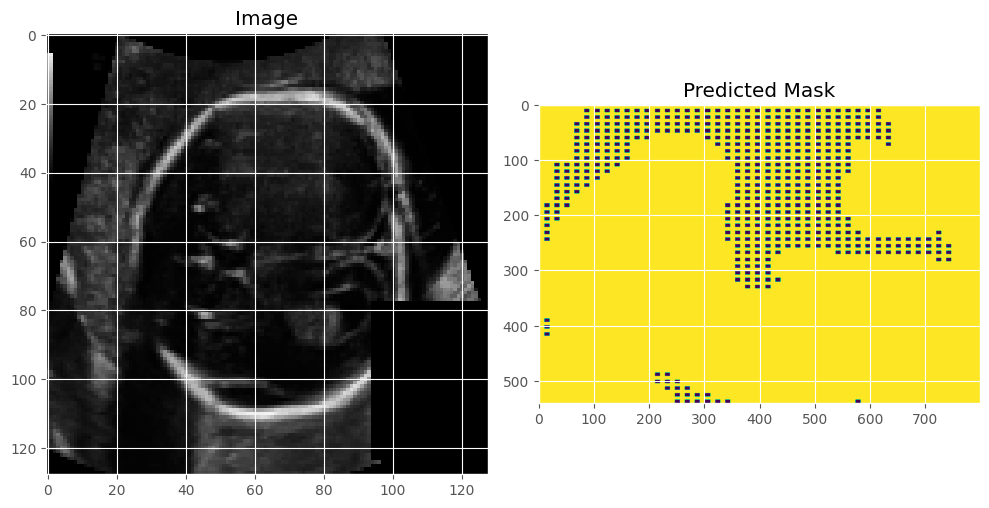

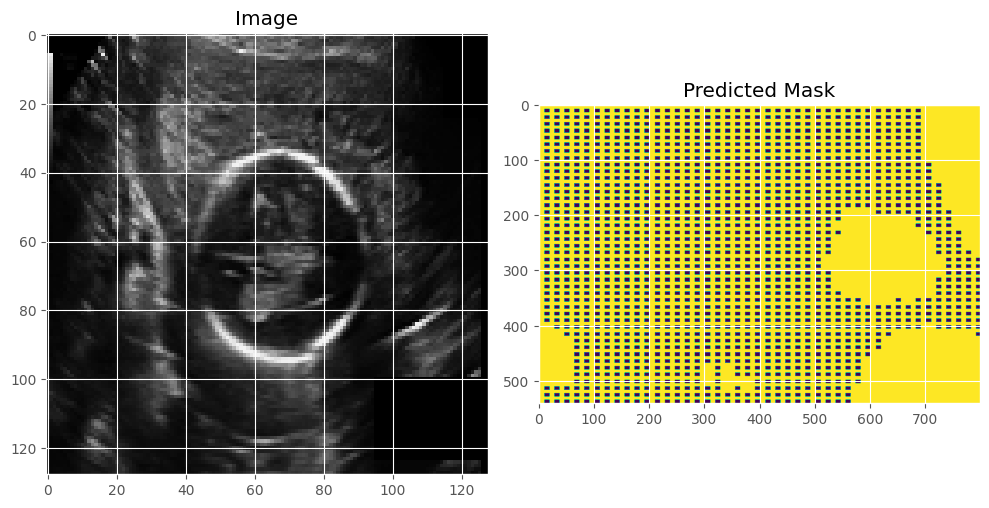

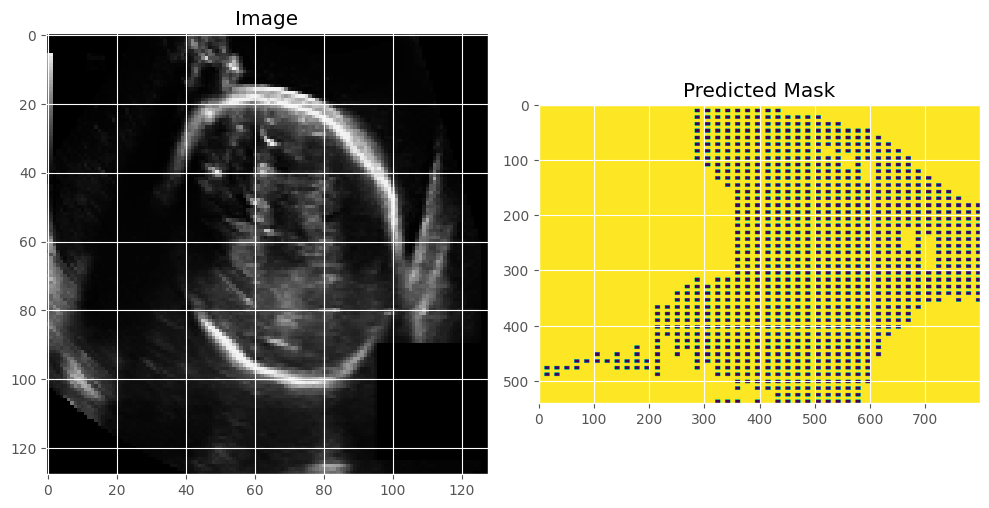

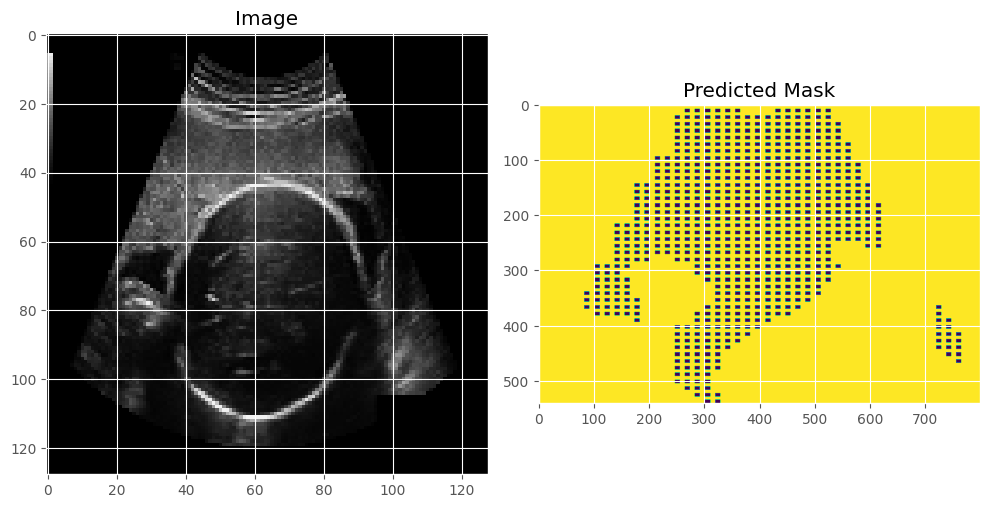

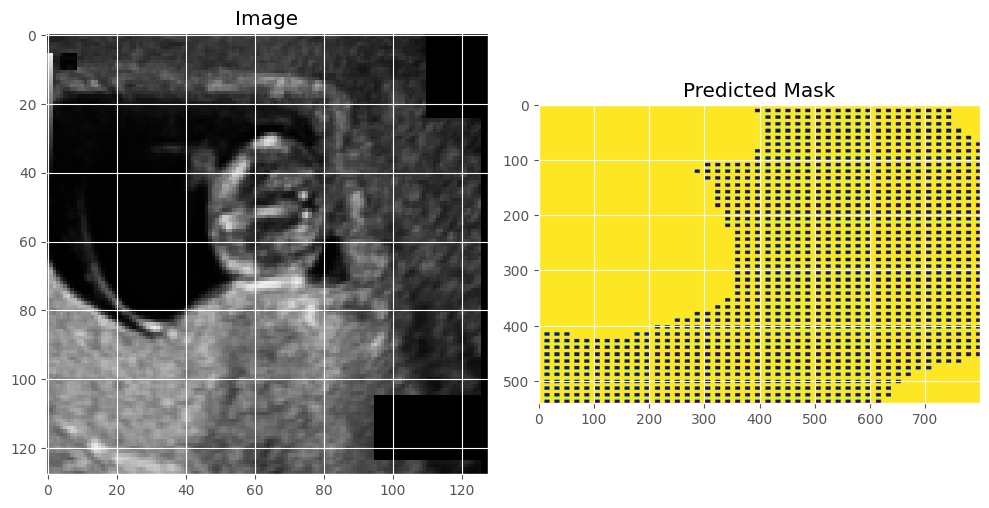

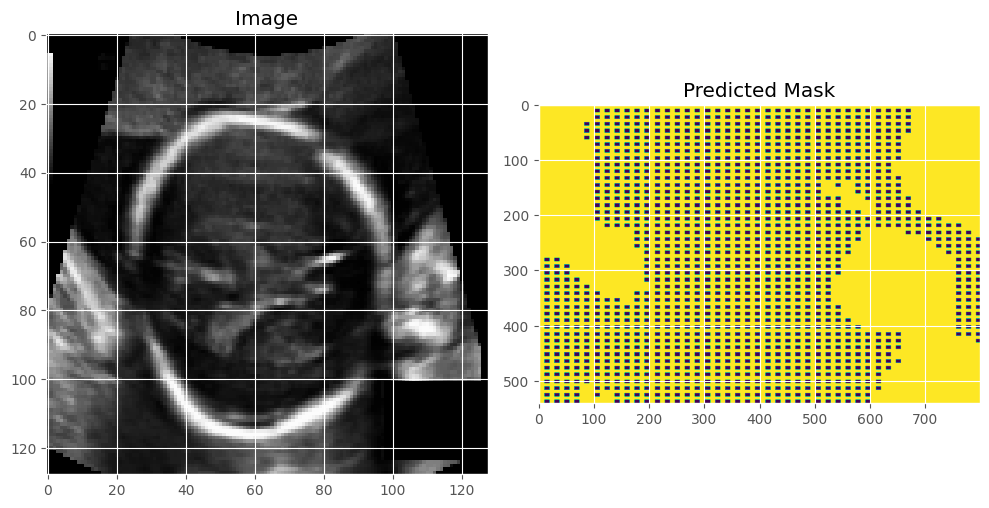

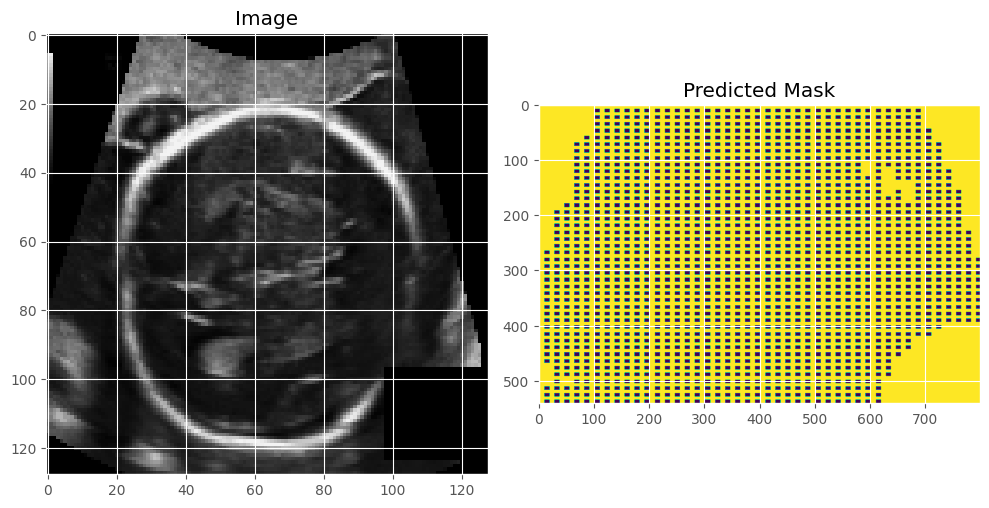

In [71]:
print("[INFO] loading up test image paths...")
imagePaths2 = open(TEST_PATHS2).read().strip().split("\n")
imagePaths2 = np.random.choice(imagePaths2, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths2:
	# make predictions and visualize the results
	make_predictions(unet, path)